In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from IPython.display import clear_output
import time

from numpy.ctypeslib import ndpointer
import ctypes

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob

# 입력 데이터
각 데이터는 분단위의 시계열 데이터로 나타난다.  
결측값은 interpolate로 채워 넣었으며, 총 1815958개의 행을 가지고 있다.  

In [2]:
tickers = ['BTC', 'ETH', 'XRP', 'DOGE','ETC']
path = './data/'+tickers[0]+'-M.csv'
df = pd.read_csv(path,parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head()

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359
2018-09-19 23:53:00,7188000.0,7188000.0,7188000.0,7188000.0,0.002734
2018-09-19 23:54:00,7188000.0,7188000.0,7187000.0,7187000.0,0.006945


### pred 열
원하는 변동률에 도달하는 기간을 나타낸다.  
상승의 경우 양수로, 하강의 경우 음수로 나타내며, 각 절대값은 도달하는 기간이다.  
예) per(df, 0.05) 에서 2490의 경우 2490분 후에 5%만큼 상승한다는 것을 나타낸다.  

Python의 경우 속도가 느려 C언어를 이용한 동적 라이브러리를 사용하였다. 

In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.05)

# Custom DataSet 생성  
dataloader로 변환  

### 전처리
각 항목들을 직전에 대한 변동률을 %로 나타내었으며  
예측값을 포함한 전부 절대값 최대의 나눗셈으로 정규화를 하였다. 

해당 정규화를 통해 예측값이 -1에 가까울수록 하향추세, 1에 가까울수록 상승추세를 나타낸다. 

In [7]:
from pymodule.dataMod import OHLCDataset
dataset = OHLCDataset(df[10:-4], pred[10:-4], 50)

해당 데이터를 분 데이터, 10분 데이터, 1시간 데이터, 일 데이터로 정규화하였으며,  
모델의 입력 데이터는 4차원으로 쌓아서 나타낸다. 

In [7]:
from torch.utils.data import DataLoader, random_split

test_size = 100000
train_set, test_set = torch.utils.data.random_split(dataset,[len(dataset)-test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1715958
test dataset length : 100000


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 4, 50, 5])
Labels batch shape: torch.Size([256, 1])


# 모델 설계

각각의 범위를 가진 시계열 데이터를 LSTM을 이용하여 추세를 확인한다.  
각 시계열 데이터의 추세들을 모아 하나의 결과를 나타낸다. 

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class sCNN(nn.Module):
    def __init__(self, hidden_size, num_layers,seq_length):
        super(sCNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.lstm2 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.lstm3 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.lstm4 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)
        
        self.conv1 = nn.Conv1d(in_channels=hidden_size*4, out_channels=4, kernel_size=10, stride=2)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=1,kernel_size=3, stride=2)

        self.fc1 = nn.Linear(10,1)
                
    def forward(self, x):
        x = x.permute((1,0,2,3))
        
        x1, h1 = self.lstm1(x[3])
        x2, h2 = self.lstm2(x[2], h1)
        x3, h3 = self.lstm3(x[1], h2)
        x4, _ = self.lstm4(x[0], h3)

        x = torch.cat((x1,x2,x3,x4),2).permute((0,2,1))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x.flatten(1))
        return x
    
model = sCNN(hidden_size = 10, num_layers = 3, seq_length = seq_length).to(device)

# 모델 최적화

In [10]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

def fit(epoch, model, data_loader, phase):
    if phase == 'train':
        model.train()
    if phase == 'valid':
        model.eval()
    
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if phase == 'train':
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.permute(1,0), target.permute(1,0))
        running_loss += loss.item()
        
        if phase == 'train':
            loss.backward()
            optimizer.step()
        
    loss = running_loss / len(data_loader.dataset)
    
    print (f'epoch:{epoch}, {phase}loss is {loss}')
    return loss

In [11]:
path = "./sCNN.pt"
model = torch.load(path).to(device)
losses = []
val_losses = []
start = time.time()
for epoch in range(20):
    epoch_loss = fit(epoch,model,train_dataloader, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dataloader, phase ='valid')
    val_losses.append(val_epoch_loss)
    torch.save(model,path)
    print((time.time()-start)/60)

epoch:0, trainloss is 1.9008297122129284e-05
epoch:0, validloss is 3.7980283116921785e-05
5.9411202271779375
epoch:1, trainloss is 1.900777480182768e-05
epoch:1, validloss is 3.7980032949708404e-05
11.721335609753927
epoch:2, trainloss is 1.900621233536984e-05
epoch:2, validloss is 3.7980086570605636e-05
17.95011894305547
epoch:3, trainloss is 1.901061871756029e-05
epoch:3, validloss is 3.798000173643231e-05
23.915537476539612
epoch:4, trainloss is 1.900710305649666e-05
epoch:4, validloss is 3.7979960828088225e-05
29.883433457215627
epoch:5, trainloss is 1.9007667193174155e-05
epoch:5, validloss is 3.797957211267203e-05
35.99722819328308
epoch:6, trainloss is 1.9007449057814438e-05
epoch:6, validloss is 3.797994116321206e-05
42.180324137210846
epoch:7, trainloss is 1.9008103387095592e-05
epoch:7, validloss is 3.797989125363529e-05
48.469801823298134
epoch:8, trainloss is 1.9008550157160122e-05
epoch:8, validloss is 3.7980132144875824e-05
54.6625892440478
epoch:9, trainloss is 1.9008692

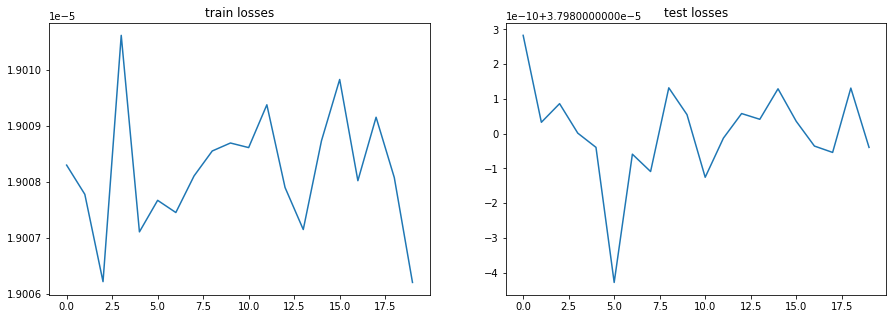

In [12]:
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('train losses')

ax[1].plot(val_losses)
ax[1].set_title('test losses')
plt.show()